In [8]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle
from sklearn.metrics import pairwise_distances

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'
#Path for loading individual samples
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC1397*/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='Fltp_2y_pp'

## Load data (filtered)

In [4]:
# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13976/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13975/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13974/filtered_feature_bc_matrix.h5ad


In [5]:
# Sample names
file_diffs

['MUC13976', 'MUC13975', 'MUC13974']

In [6]:
adata

AnnData object with n_obs × n_vars = 22501 × 31129
    obs: 'leiden_r1_normscl', 'file'
    obsm: 'X_umap_normscl'

Information about the experiments:

In [7]:
# Add sample experimental information
sorting_dict = {'MUC13974' : 'mRFP', 'MUC13975' : 'mTmG', 'MUC13976': 'mGFP'}
adata.obs['sorting']=[sorting_dict[file] for file in adata.obs.file]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [12]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

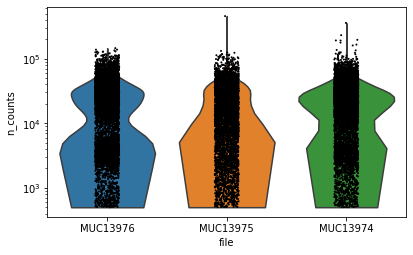

In [7]:
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [4]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files:
    print('Reading file',file)
    #adatas_raw.append(sc.read_h5ad(file))
    adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13976/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13975/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/scanpy_AnnData/MUC13974/raw_feature_bc_matrix.h5ad


In [5]:
adata_raw

AnnData object with n_obs × n_vars = 20384640 × 31129
    obs: 'file'

In [7]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [13]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 20362139 out of all drops: 20384640 -> remaining: 22501


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


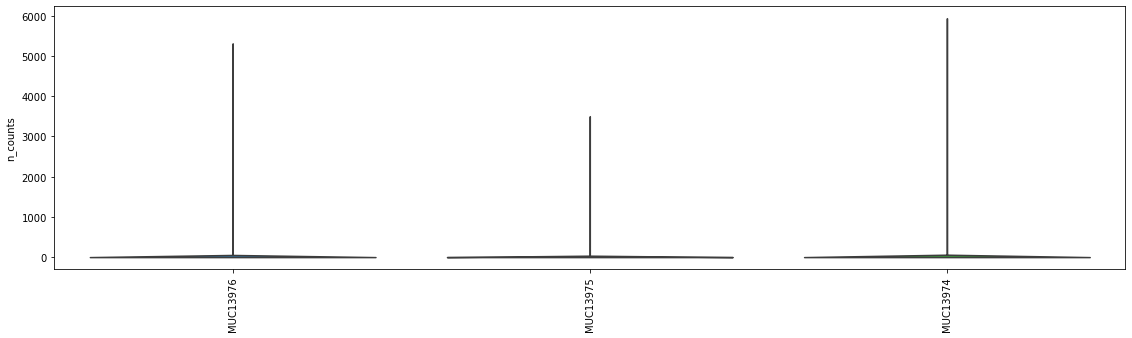

In [14]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [8]:
print('N cells per non-filtered sample')
adata_raw.obs['file'].value_counts()

N cells per non-filtered sample


MUC13974    6794880
MUC13975    6794880
MUC13976    6794880
Name: file, dtype: int64

In [9]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

filtered out 13184598 cells that have less than 1 counts
filtered out 8102 genes that are detected in less than 1 cells


In [10]:
adata_raw

AnnData object with n_obs × n_vars = 7200042 × 23027
    obs: 'file', 'n_counts'
    var: 'n_cells'

Cell N counts sorted by cell N counts rank without all 0 cells. 

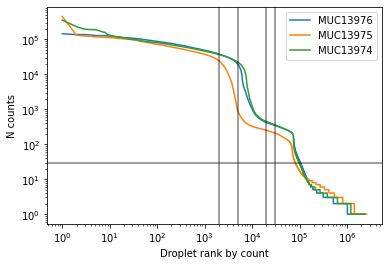

In [11]:
# For each file plot N count vs cell rank by count with log axes
fig, ax=plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(2000,c='k',alpha=0.5)
ax.axvline(5000,c='k',alpha=0.5)
ax.axvline(20000,c='k',alpha=0.5)
ax.axvline(30000,c='k',alpha=0.5)
ax.axhline(30,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [18]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

In [19]:
%%R -i sparse_mat -i genes -i barcodes -o ambient_scores
# Run emptyDrops and output scores per gene
sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce),BPPARAM=MulticoreParam(workers = 16))
#is_cell <- ambient$FDR <= 0.05
#threshold_ambient <- 0.005
#ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
ambient_scores <- as.data.frame(ambient@metadata$ambient)
#barcodes_filtered <- barcodes[which(is_cell)]

emptyDrops top ambient genes with scores.

In [20]:
ambient_scores.columns=['ambient_score']
ambient_scores.sort_values('ambient_score',ascending=False).query('ambient_score>=0.005')

,ambient_score
Ins2,0.293021
Ins1,0.112568
Iapp,0.018241
mt-Co3,0.017538
mt-Atp6,0.015153
Malat1,0.013952
mt-Co2,0.012054
mt-Co1,0.011730
Ppy,0.008352
Gcg,0.008236


Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [12]:
ambient_vars=['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts']=adata_raw[adata_raw.obs['n_counts']<100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
Ins2       0.783182
Ins1       0.310760
Iapp       0.049520
mt-Co3     0.047677
mt-Atp6    0.041240
Malat1     0.037994
mt-Co2     0.032886
mt-Co1     0.032008
Ppy        0.022775
Gcg        0.022468
mt-Cytb    0.020576
Gm42418    0.019605
Fth1       0.013305
mt-Nd4     0.012664
Tmsb4x     0.011776
mt-Nd2     0.010633
Actb       0.009991
Pyy        0.009891
S100a9     0.008726
Ftl1       0.007930
Name: mean_ambient_n_counts, dtype: float32

#C: The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [13]:
# Mean empty expression in individual samples
for file in adata_raw.obs.file.cat.categories:
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts']<100)
                                                  ].X.mean(0).A1
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
for file in adata_raw.obs.file.cat.categories:
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][
        np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

In [14]:
# Normalise ambient scores
ambient_df=adata_raw.var[ambient_vars]
ambient_df=ambient_df.loc[ambient_genes,ambient_vars]/ambient_df.sum(axis=0)

<AxesSubplot:ylabel='index'>

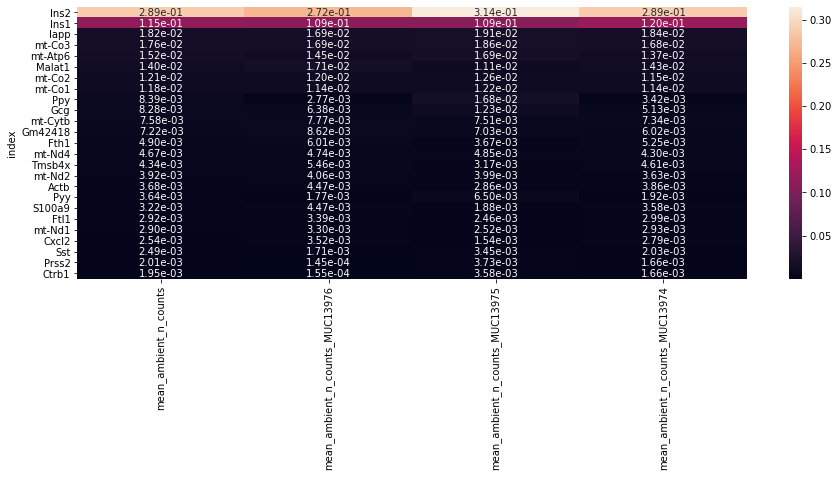

In [23]:
# Display ambient genes across samples
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts',ascending=False).iloc[:20,:],annot=True,fmt='.2e')

In [15]:
# Save ambient DF for top N genes
if SAVE:
    ambient_df.to_csv(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t')

In [25]:
# Save genes with scaled mean ambient expression at least > 0.003 in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
ambient_genes_selection=list(ambient_df[(ambient_df>0.003).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['Pyy', 'mt-Nd4', 'mt-Co2', 'Tmsb4x', 'Cxcl2', 'Ins1', 'mt-Atp6', 'Ins2', 'Ppy', 'Sst', 'mt-Co3', 'mt-Nd2', 'S100a9', 'Ctrb1', 'Gm42418', 'Malat1', 'mt-Cytb', 'Ftl1', 'Fth1', 'Prss2', 'mt-Co1', 'mt-Nd1', 'Iapp', 'Gcg', 'Actb']


#### Proportion of ambience based on ambient threshold
All calculations are based on removing ambient genes from single sample, except for the plot line 
"N removed genes across samples" that represents N removed genes at threshold across all samples

In [16]:
# Calculate retained ambient proportion and sum(abs(ambient_mean_geneI-ambient_sample_geneI))
# for ambient gene removal thresholds. Ambient genes are removed per sample.
thresholds=list(1/np.logspace(1,18,num=300,base=2,dtype='int'))
ambient_diffs=pd.DataFrame(columns=adata_raw.obs.file.unique())
removed_genes=pd.DataFrame(columns=list(adata_raw.obs.file.unique())+['all'])
ambient_proportions=pd.DataFrame(columns=adata_raw.obs.file.unique())
for idx,threshold in enumerate(thresholds):
    ambient_df_sub=ambient_df[~(ambient_df>threshold).any(axis=1)]
    removed_genes.at[idx,'all']=adata_raw.shape[1]-ambient_df_sub.shape[0]
    for sample in adata_raw.obs.file.unique():
        ambient_df_sub=ambient_df[~(ambient_df['mean_ambient_n_counts_'+sample]>threshold)]
        removed_genes.at[idx,sample]=adata_raw.shape[1]-ambient_df_sub.shape[0]
        diff=abs(ambient_df_sub['mean_ambient_n_counts']-ambient_df_sub['mean_ambient_n_counts_'+sample]).sum()
        ambient_diffs.at[idx,sample]=diff
        ambient_proportions.at[idx,sample]=ambient_df_sub['mean_ambient_n_counts_'+sample].sum()

In [28]:
AMBIENT_THR=0.01

In [29]:
#Difference between mean and per sample ambient scores for retained genes
#and N removed genes across samples

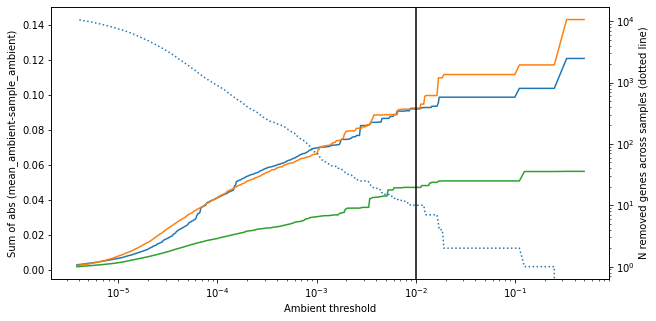

In [30]:
# Difference to average ambient scores for retained genes at each threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
ax2 = ax.twinx()  
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_diffs[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of abs (mean_ambient-sample_ambient)')
ax.set_xlabel('Ambient threshold')
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [20]:
#Retained ambient proportion per sample
#and N removed genes across samples

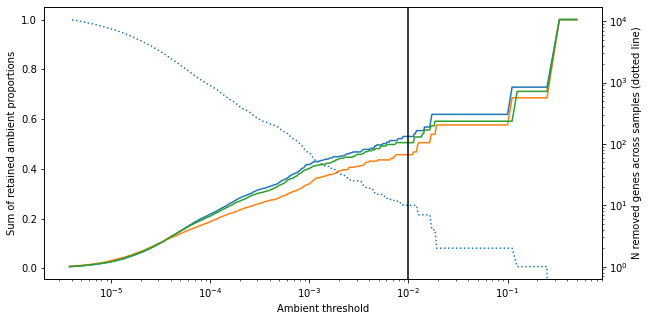

In [31]:
# Retained ambience per sample vs threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_proportions[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of retained ambient proportions')
ax.set_xlabel('Ambient threshold')
ax2 = ax.twinx()  
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [22]:
#N removed genes per sample

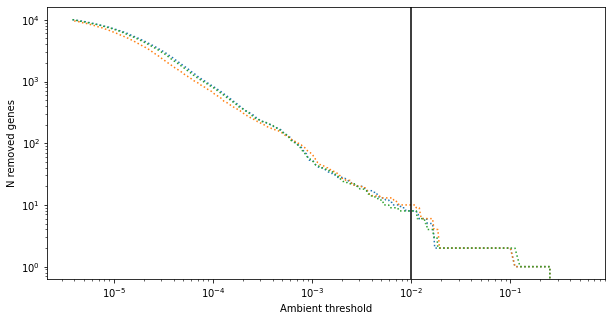

In [32]:
# N removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,removed_genes[sample],linestyle='dotted')
ax.set_xscale('log')
ax.set_ylabel('N removed genes')
ax.set_xlabel('Ambient threshold')
ax.set_yscale('log')
plt.axvline(AMBIENT_THR,c='k')

In [24]:
#Removed ambience proportion divided by removed genes per sample

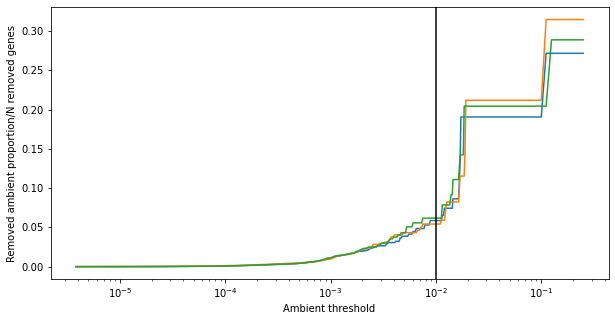

In [33]:
# Comparison of removed ambience vs N of removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    any_removed=np.array(removed_genes[sample])>0
    ax.plot(np.array(thresholds)[any_removed],((1-ambient_proportions[sample])/removed_genes[sample])[any_removed])
ax.set_xscale('log')
ax.set_ylabel('Removed ambient proportion/N removed genes')
ax.set_xlabel('Ambient threshold')
plt.axvline(AMBIENT_THR,c='k')

In [34]:
# Save genes with scaled mean ambient expression at least > threshold in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
ambient_genes_selection=list(ambient_df[(ambient_df>AMBIENT_THR).any(axis=1)].index)

print('N selected ambient genes:',len(ambient_genes_selection))
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection_extended.pkl", "wb" ) )

N selected ambient genes: 10


In [ ]:
del adata_raw

## QC (counts, genes, mt)

In [13]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [102]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Rgs5', 'Gcg', 'Chgb', 'Tmsb4x', 'Cpb1', 'S100a9', 'Cela3b', 'Cela2a', 'Jchain', 'Cpa1', '2210010C04Rik', 'Try4', 'Try5', 'Prss2', 'Igkc', 'Reg1', 'Ghrl', 'Mgp', 'Iapp', 'Apoe', 'Sycn', 'Ftl1', 'Hbb-bt', 'Hbb-bs', 'Ins2', 'Ctrl', 'Ctrb1', 'Hba-a1', 'Hba-a2', 'Ccl5', 'Ccl4', 'Ppy', 'Pyy', 'Chga', 'Igha', 'Ighg2b', 'Ighm', 'Cela1', 'Sst', 'Clps', 'Gm26917', 'Gm42418', 'Ttr', 'Cd74', 'Malat1', 'Fth1', 'Ins1', 'Pnlip', 'Pnliprp1', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


computing PCA
    with n_comps=15
    finished (0:00:16)


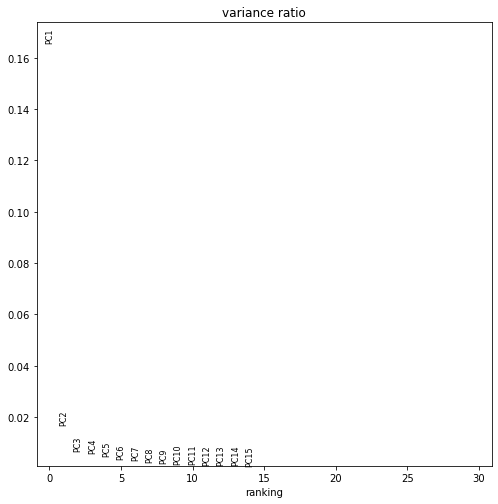

In [103]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [104]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=5, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


... storing 'sorting' as categorical


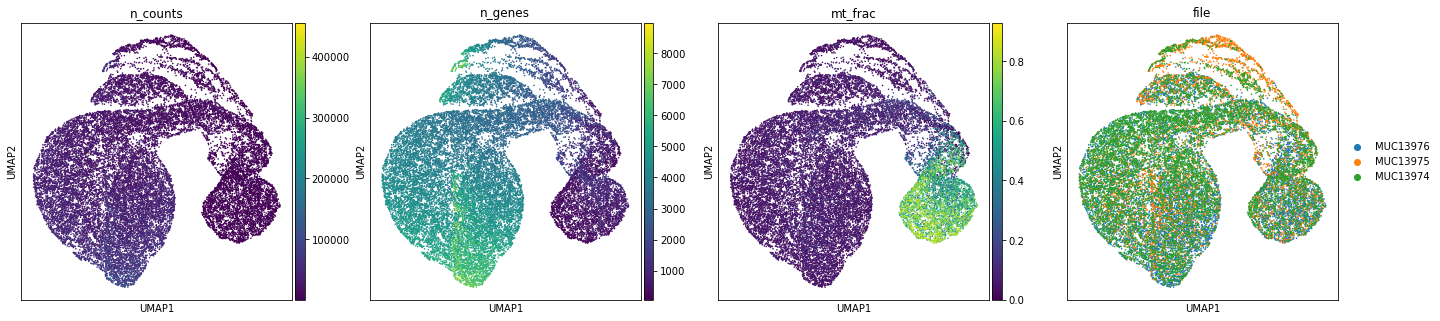

In [105]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
#TODO File was not plotted
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

#C: Low n_genes cells have high mt_frac and high n_counts cells have high n_genes. There seem to be no surprising differences between subpopulations in terms of QC scores that may indicate special QC subpopulations.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

... storing 'sorting' as categorical


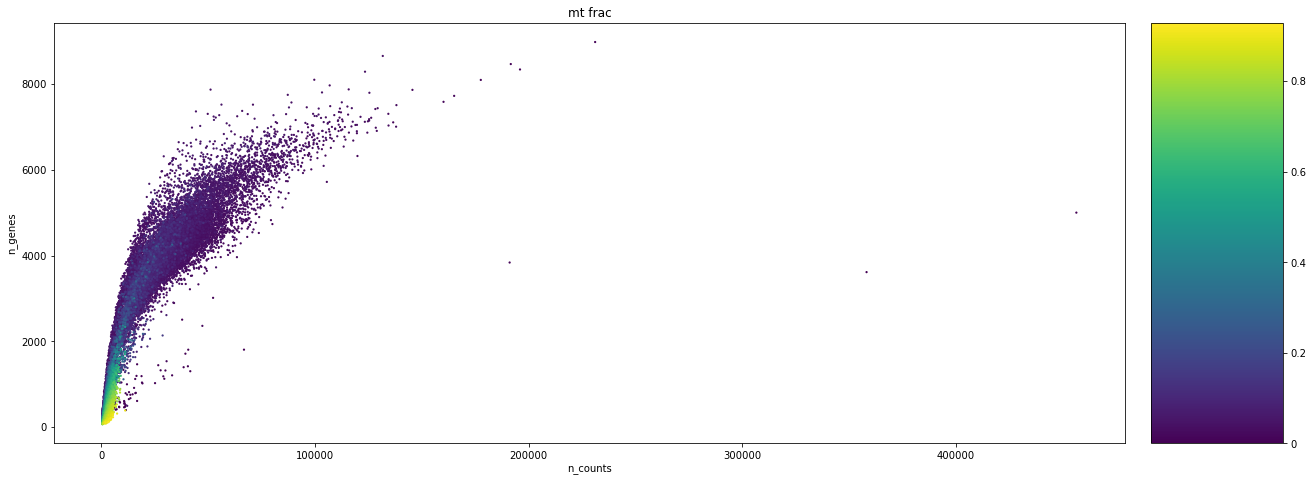

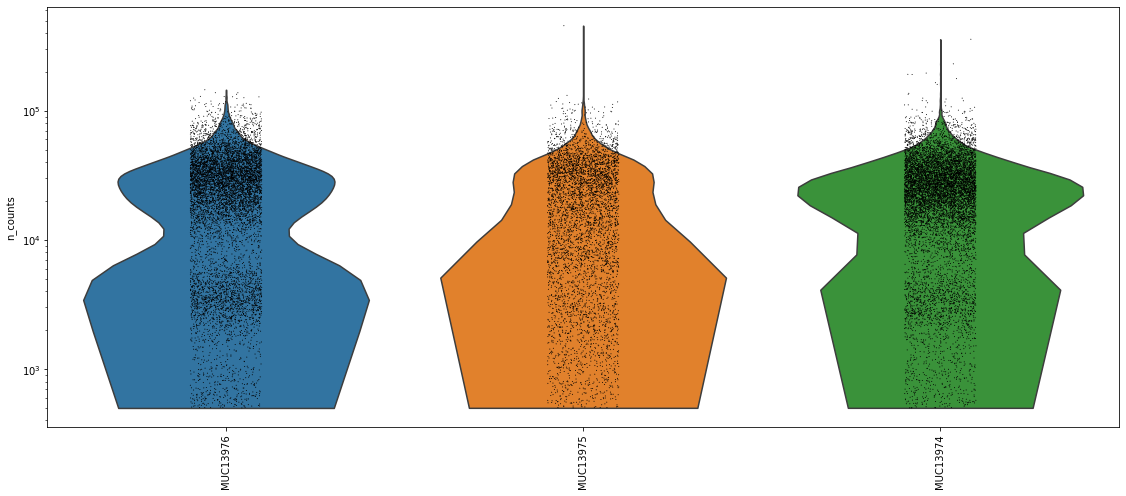

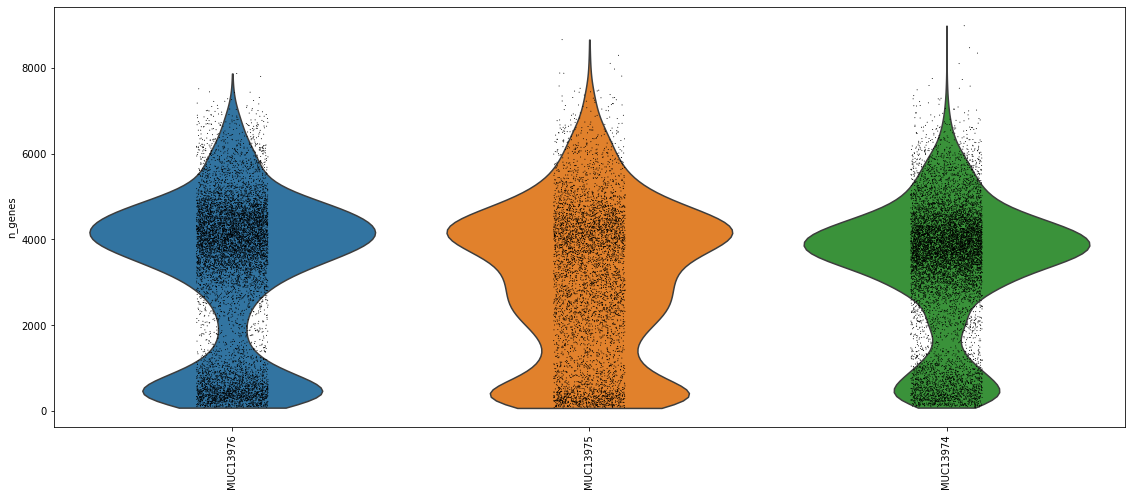

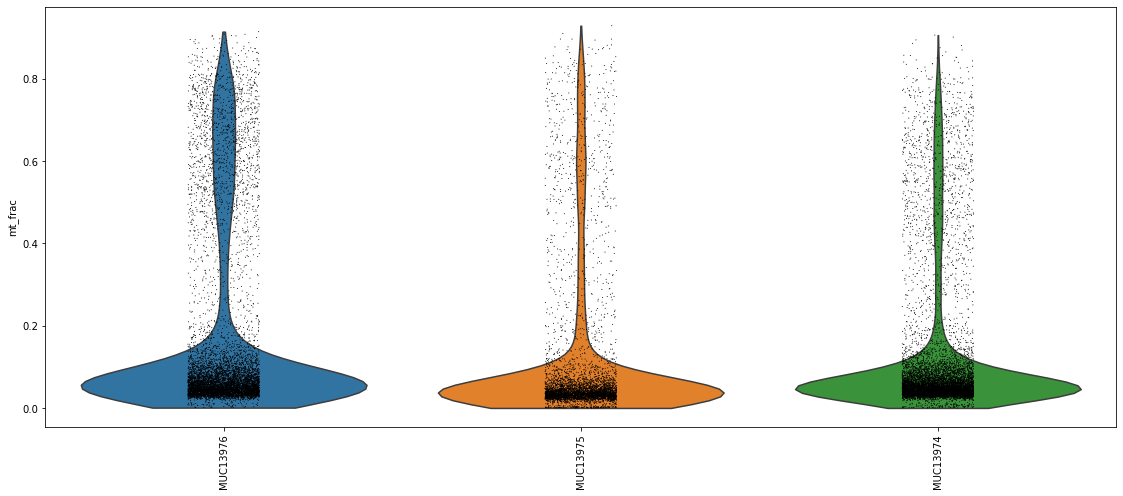

In [106]:
#Data quality summary plots
rcParams['figure.figsize']=(15,8)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

Correlation with ambient expression

In [9]:
# Calculate correlation of each sample with its ambient expression ratios
# Load ambient ratios
ambient_df=pd.read_table(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t',index_col=0)
adata.obs['ambient_correlation']=np.nan
for file in adata.obs.file.unique():
    indices=adata.obs_names[adata.obs.file==file]
    # Correlation between expression and ambient ratios of that sample
    # Convert correlation distance to correlation
    adata.obs.loc[indices,'ambient_correlation']=1-pairwise_distances(
        # Select genes included in ambient computation (non-null)
                       adata[indices,ambient_df.index].X.toarray(),
                       ambient_df['mean_ambient_n_counts_'+file].values.reshape(1,-1),
                       metric='correlation').ravel()

... storing 'leiden_r1_normscl' as categorical
... storing 'sorting' as categorical


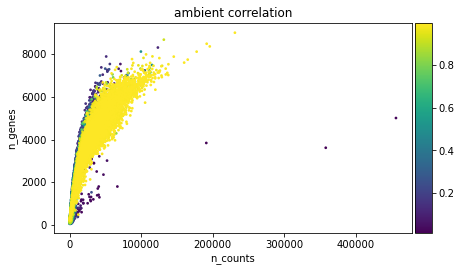

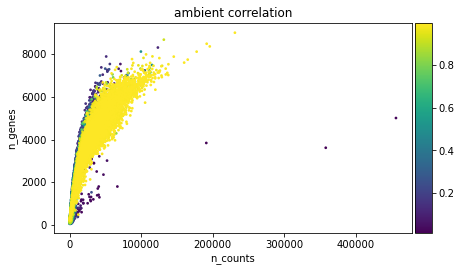

In [14]:
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='ambient_correlation', size=30)
p2 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='ambient_correlation', size=30,
                   sort_order=False)

C: Ambient correlation is not informative as it is high for most cells..

N counts:

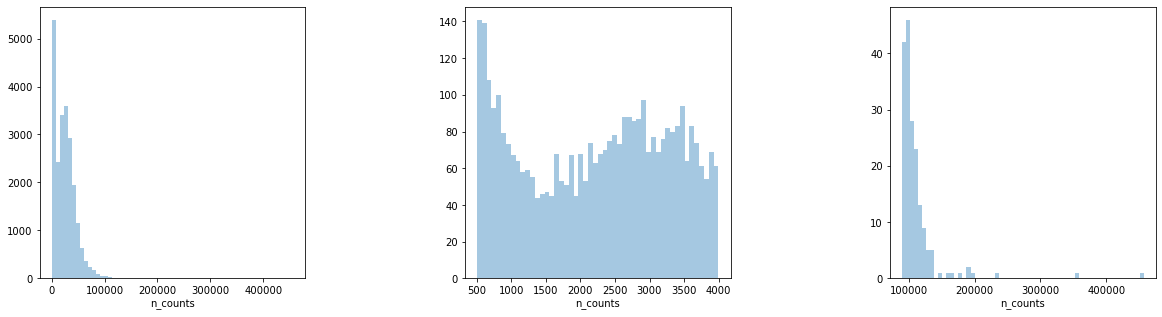

In [107]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=60)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_xscale('log')
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>90000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

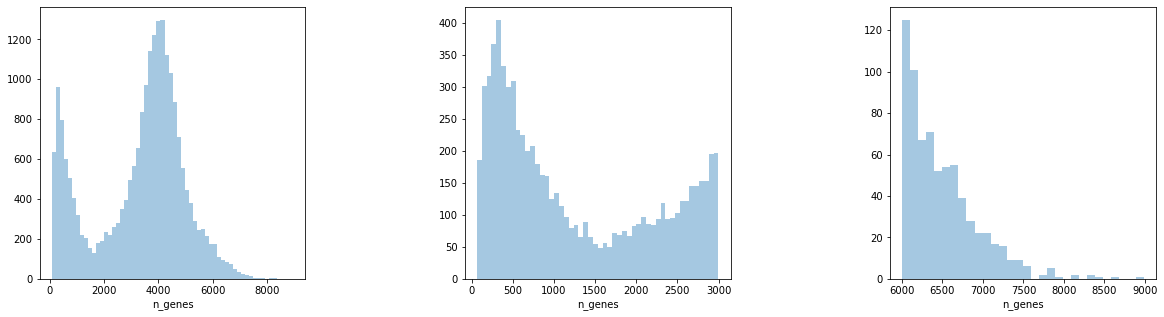

In [108]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<3000], 
                 kde=False, bins=50, ax=fig.add_subplot(fig_ind[1]))
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>6000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

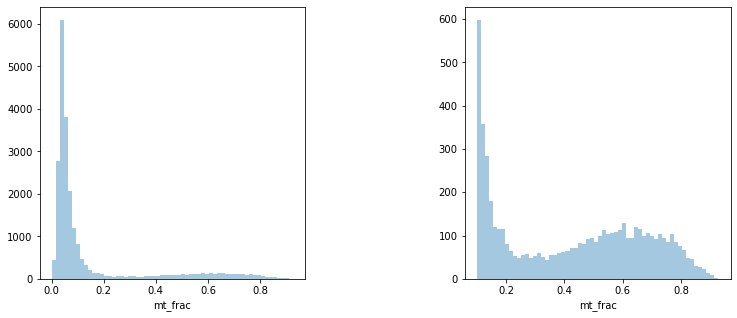

In [109]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [110]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

ok      21354
low      1145
high        2
Name: n_counts_filter, dtype: int64


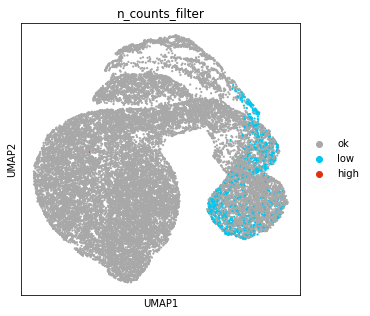

In [112]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=1500
COUNTS_THR_MAX=300000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      17741
low      4753
high        7
Name: n_genes_filter, dtype: int64


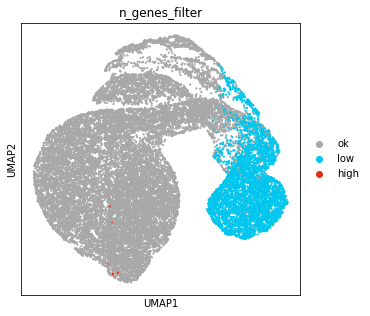

In [113]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=1500
GENES_THR_MAX=8000
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      18726
high     3775
Name: mt_frac_filter, dtype: int64


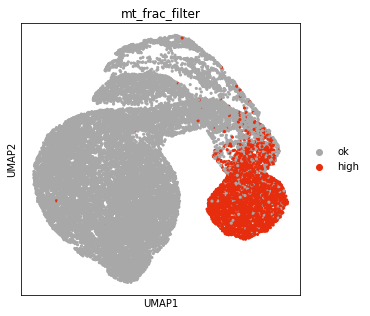

In [114]:
param='mt_frac'
MT_THR=0.22
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: Filtering out high N genes cells does not seem to be very important yet. The few very high N counts cells will be filtered out.

N cells in which a gene is expressed:

In [47]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

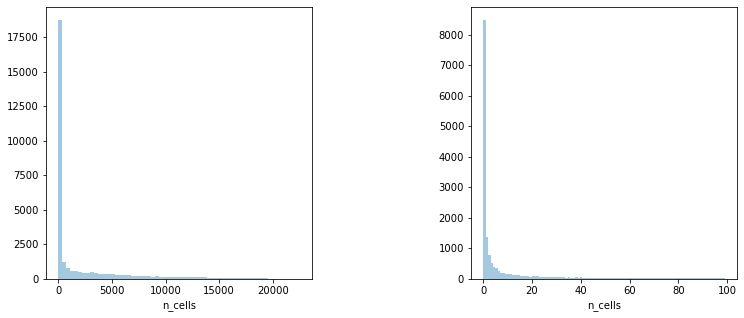

<AxesSubplot:xlabel='n_cells'>

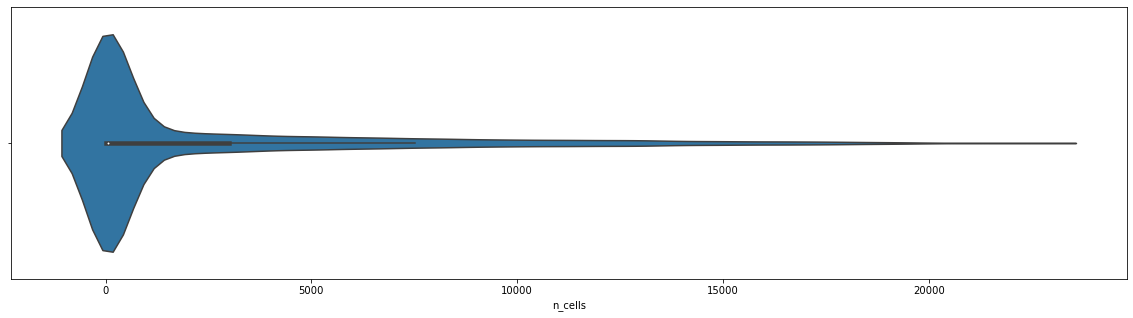

In [48]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [116]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts = COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))


adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 22501
filtered out 1145 cells that have less than 1500 counts
Number of cells after min count filter: 21356
filtered out 2 cells that have more than 300000 counts
Number of cells after max count filter: 21354
Number of cells after MT filter: 18170
filtered out 608 cells that have less than 1500 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 17562


In [117]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31129
filtered out 13958 genes that are detected in less than 20 cells
Number of genes after cell filter: 17171


## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [118]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

MUC13976 N cells: 6135
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 12.5%
Elapsed time: 6.6 seconds
MUC13975 N cells: 3796
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 9.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.9%
Elapsed time: 3.7 seconds
MUC13974 N cells: 7631
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1

Distribution of doublet scores

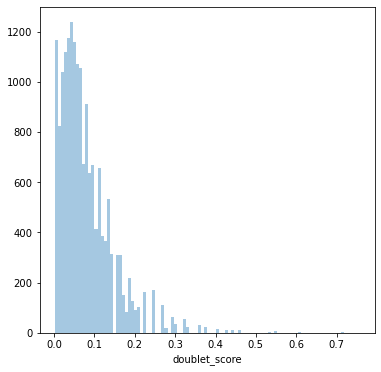

... storing 'doublet' as categorical


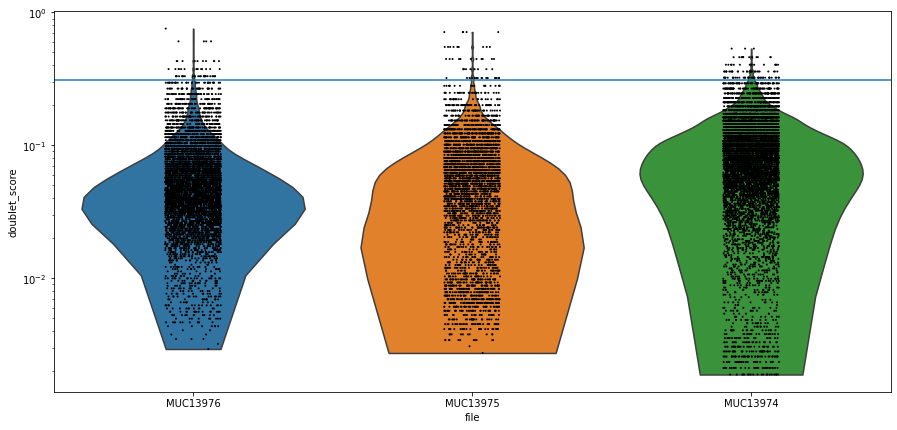

In [119]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.31
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


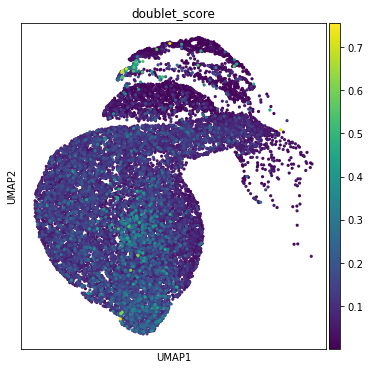

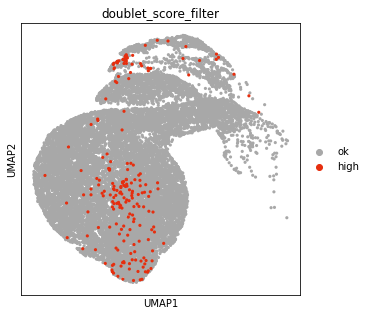

Doublet assignment:
 ok      17361
high      201
Name: doublet_score_filter, dtype: int64


In [120]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]
# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index,:], color=[param+'_filter'],size=40)
print('Doublet assignment:\n',adata.obs[param+'_filter'].value_counts())

In [121]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 17562
Number of cells after doublet filter: 17361


## Summary after QC

In [122]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
MUC13976,4206.4,4170.0,34283.0,30972.0,6081.0
MUC13975,3869.3,3941.0,28136.3,25712.5,3746.0
MUC13974,3963.1,3914.0,30343.7,27262.5,7534.0


In [123]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 2952.0 - 231130.0
N genes range: 1501 - 8983
Mt fraction range: 6.391e-04 - 2.183e-01
Doublet score range: 1.891e-03 - 2.963e-01
N cellls expressing a gene range: 20 - 17562


## Save QC data

In [124]:
# Save QC data
if SAVE:
    #adata.write(shared_folder+'data_QC.h5ad')
    h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
    #pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [85]:
# Load QC data
#adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [125]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 17171
Number of genes after ambient removal: 17146


In [126]:
adata.layers['counts'] = adata.X.copy()

In [127]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Chgb', 'Cela3b', 'Cela2a', 'Jchain', 'Cpa1', '2210010C04Rik', 'Try4', 'Try5', 'Igkc', 'Reg1', 'Ghrl', 'Mgp', 'Apoe', 'Sycn', 'Hbb-bt', 'Hbb-bs', 'Ctrl', 'Hba-a1', 'Hba-a2', 'Ccl4', 'Chga', 'Igha', 'Ighm', 'Cela1', 'Clps', 'Ttr', 'Cd74', 'Pnlip']
    finished (0:00:02)
computing PCA
    with n_comps=15
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


Cluster cells for scran normalisation

In [128]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering
    finished: found 21 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:04)
N clusters: 21


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [129]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


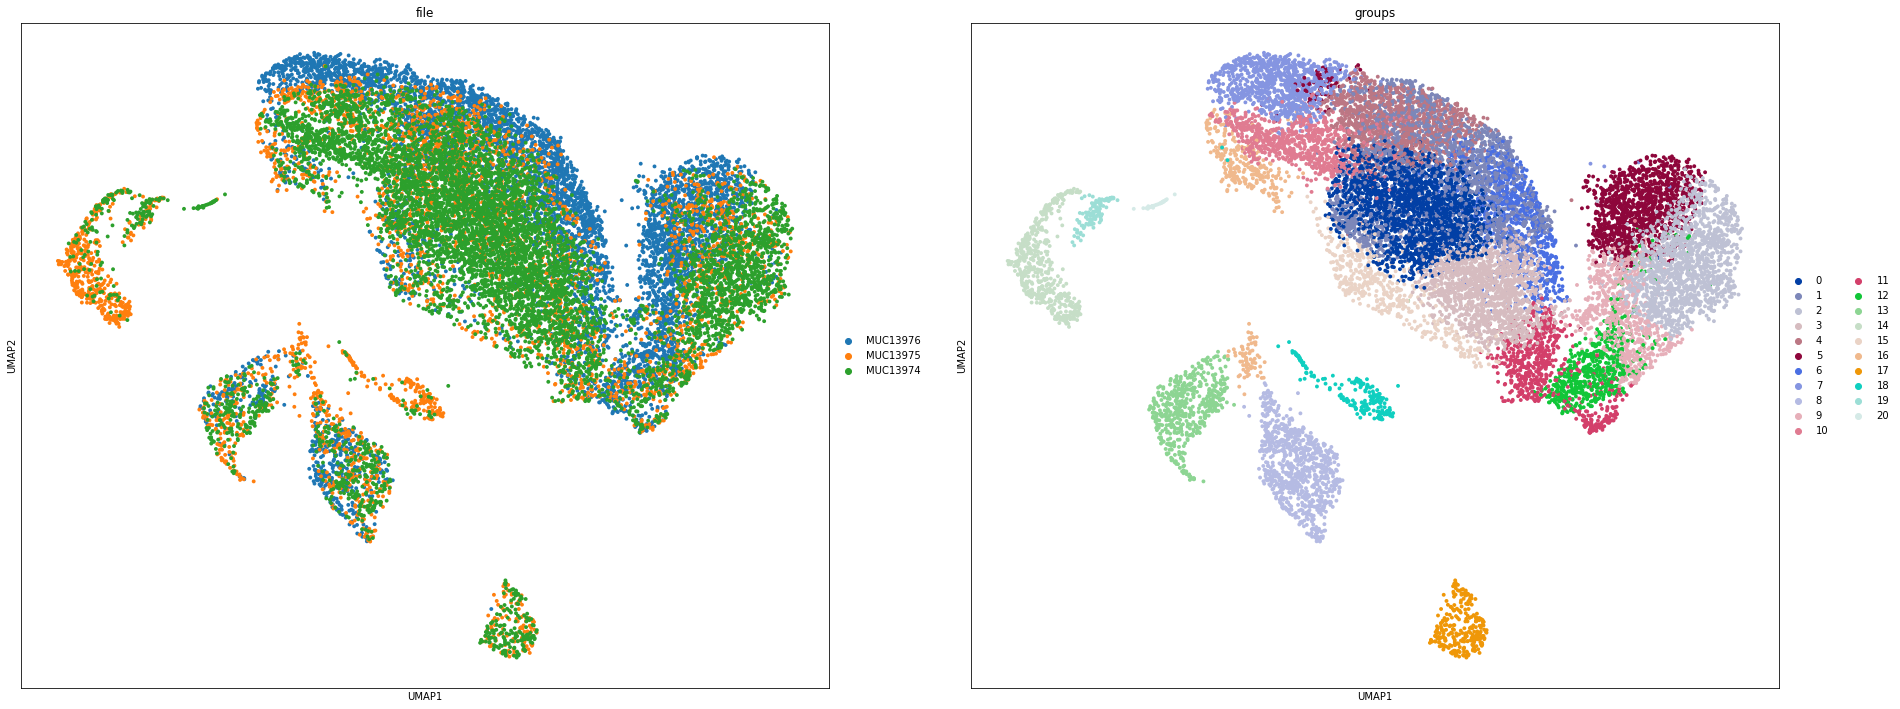

In [130]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [132]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [133]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

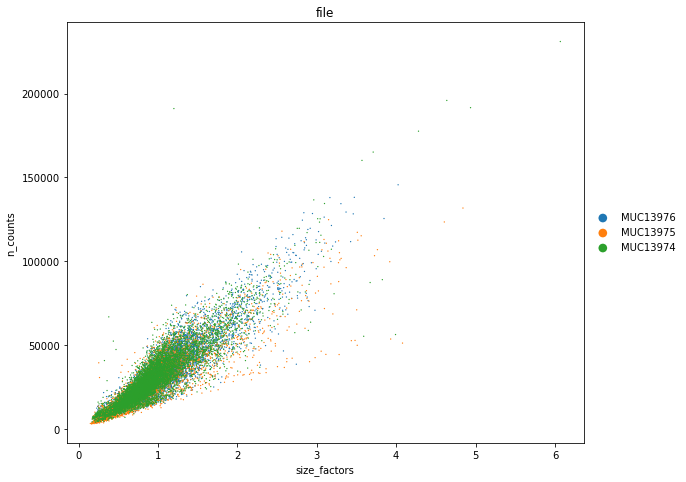

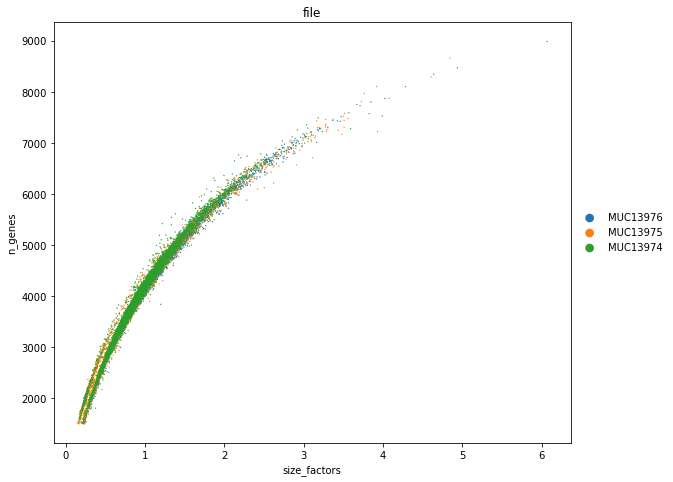

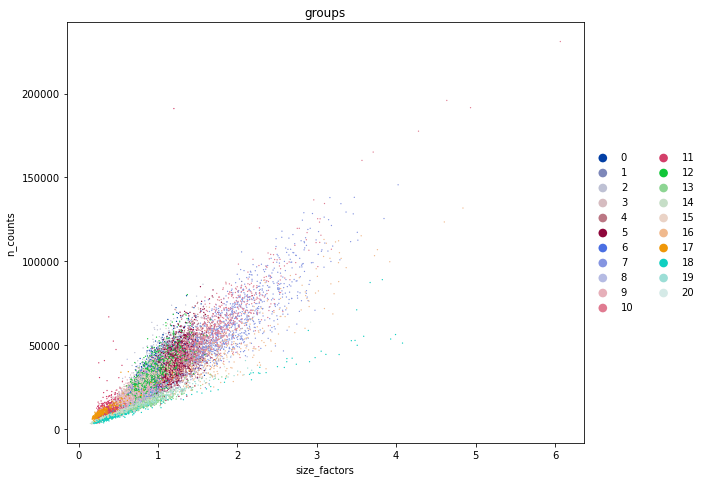

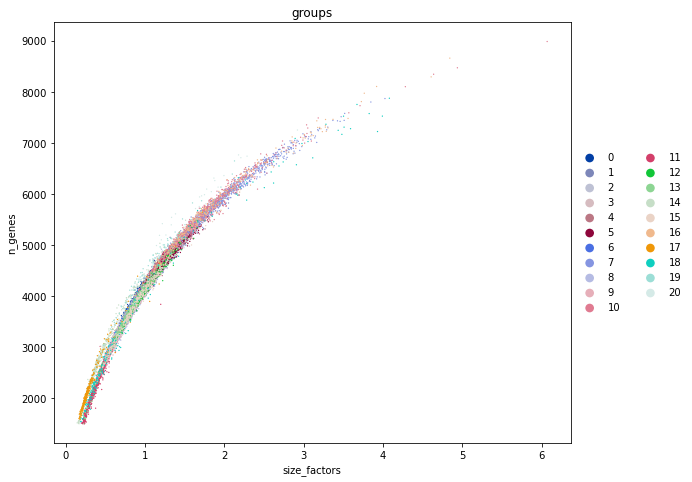

Distribution of size factors


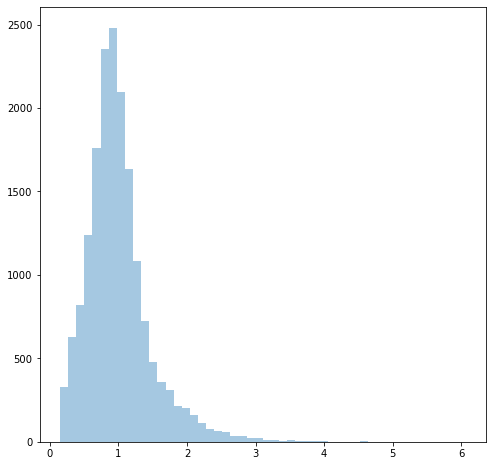

In [134]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [135]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [55]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [56]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

In [136]:
adata

AnnData object with n_obs × n_vars = 17361 × 17146
    obs: 'file', 'sorting', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells'
    uns: 'file_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'mt_frac_filter_colors', 'doublet_score_filter_colors', 'log1p'
    layers: 'counts'

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


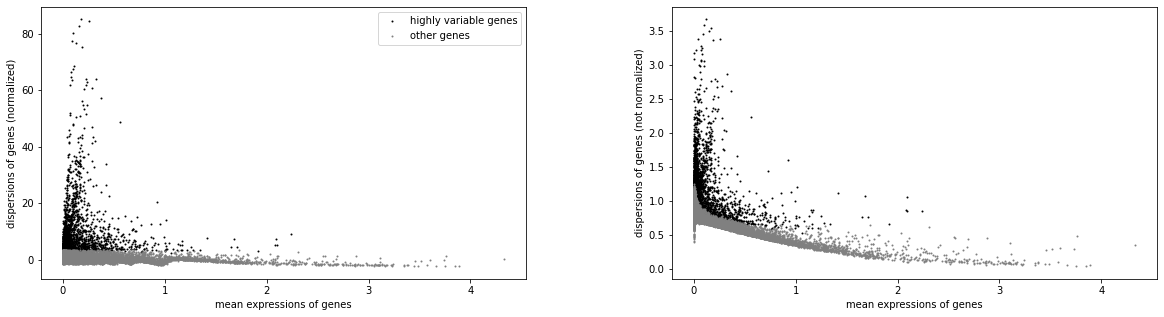

In [137]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

## Save normalised data

In [138]:
if SAVE:
    h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)